# 5. Running a full analysis

*Written by Jin Hyun Cheong and Eshin Jolly*

In this tutorial we'll perform a real analysis on the dataset from ["A Data-Driven Characterisation Of Natural Facial Expressions When Giving Good And Bad News"](https://journals.plos.org/ploscompbiol/article/peerReview?id=10.1371/journal.pcbi.1008335) by Watson & Johnston 2020.  You can try it out interactively in Google Collab: [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/cosanlab/py-feat/blob/master/notebooks/content/04_fex_analysis.ipynb)

In this analysis, we'll explore any differences in facial expressions people made when receiving good or bad news (see the original paper for more details). The full dataset is available on [OSF](https://osf.io/6tbwj/), so we'll first download the videos and their metadata. Then, we'll load up some pre-trained emotion and action-unit (AU) detectors and use them to extract AU intensity from the videos in the dataset. Finally, we'll demonstrate how easy it is to perform several different kinds of comparisons acoss experimental conditions (good vs bad) using the `Fex` data class.


In [ ]:
# Uncomment the line below and run this only if you're using Google Collab
# !pip install -q py-feat

## 5.1 Prepare Data

### 5.1.1 Download the data

First we'll need to download all 20 video files and their corresponding attributes CSV files from OSF. The next cell should run quickly on Google Collab, but will depend on your own internet conection if you're executing this notebook locally. You can rerun this cell in case the download fails for any reason, as it should skip downloading existing files:

In [1]:
import os
import glob
import subprocess
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_context("talk")

files_to_download = {
    "4c5mb": 'clip_attrs.csv',
    "n6rt3": '001.mp4',
    "3gh8v": '002.mp4',
    "twqxs": '003.mp4',
    "nc7d9": '004.mp4',
    "nrwcm": '005.mp4',
    "2rk9c": '006.mp4',
    "mxkzq": '007.mp4',
    "c2na7": '008.mp4',
    "wj7zy": '009.mp4',
    "mxywn": '010.mp4',
    "6bn3g": '011.mp4',
    "jkwsp": '012.mp4',
    "54gtv": '013.mp4',
    "c3hpm": '014.mp4',
    "utdqj": '015.mp4',
    "hpw4a": '016.mp4',
    "94swe": '017.mp4',
    "qte5y": '018.mp4',
    "aykvu": '019.mp4',
    "3d5ry": '020.mp4',
}

for fid, fname in files_to_download.items():
    if not os.path.exists(fname):
        print(f"Downloading: {fname}")
        subprocess.run(f"wget -O {fname} --content-disposition https://osf.io/{fid}/download".split())

videos = np.sort(glob.glob("*.mp4"))
print(f"Downloaded {len(videos)} videos")

Downloaded 20 videos


We'll also load an experiment attributs file and match video filenames to th experimental conditions, i.e. *good news* or *bad news*:

In [2]:
# Load in attributes
clip_attrs = pd.read_csv("clip_attrs.csv")

# Add in file names and rename conditions
clip_attrs = clip_attrs.assign(
    input=clip_attrs.clipN.apply(lambda x: str(x).zfill(3) + ".mp4"),
    condition=clip_attrs["class"].replace({"gn": "goodNews", "ists": "badNews"}),
)

# We're only using a subset of videos for this tutorial so drop the rest
clip_attrs = clip_attrs.query("input in @videos")
clip_attrs.shape
clip_attrs.head()

(20, 6)

,clipN,class,phraseN,phrase_txt,input,condition
0,1,gn,1,your loan has been approved,001.mp4,goodNews
1,2,gn,2,you've got the job,002.mp4,goodNews
2,3,gn,3,the vendor has accepted your offer,003.mp4,goodNews
3,4,gn,4,your tests have come back clear,004.mp4,goodNews
4,5,gn,5,your application has been accepted,005.mp4,goodNews


### 5.1.2 Process videos with a Detector

Now we'll initialize a new `Detector` and process each frame of each video, saving the results to csv files named after the video.

In [3]:
from feat import Detector
from tqdm import tqdm

detector = Detector()

for video in tqdm(videos):
    out_name = video.replace(".mp4", ".csv")
    if not os.path.exists(out_name):
        print(f"Processing: {video}")
        fex = detector.detect_video(video)
        fex.to_csv(out_name, index=False)

100%|██████████| 20/20 [00:00<00:00, 8613.42it/s]


### 5.1.3. Aggregate into a single Fex object

Then we can use `read_feat` to load each CSV file and concatenate them together:

In [4]:
from feat.utils.io import read_feat
import pandas as pd
from glob import glob

fex = pd.concat(map(lambda video: read_feat(video.replace(".mp4", ".csv")), videos))

fex.head()

,FaceRectX,FaceRectY,FaceRectWidth,FaceRectHeight,FaceScore,x_0,x_1,x_2,x_3,x_4,...,AU43,anger,disgust,fear,happiness,sadness,surprise,neutral,input,frame
0,236.153809,182.587204,254.930786,349.109451,0.999326,355.590267,361.166635,370.024031,382.002333,405.379242,...,0.017959,0.000438,0.000117,0.000483,0.981574,0.001495,0.013396,0.002497,001.csv,0
1,236.198212,182.582245,254.905151,349.177582,0.999327,355.947047,361.429636,370.189673,382.098332,405.381871,...,0.031311,0.000422,0.000110,0.000471,0.981490,0.001407,0.013663,0.002437,001.csv,1
2,237.683929,181.546631,254.771271,349.269104,0.999371,357.488551,363.557662,372.905629,385.126006,408.333512,...,0.022510,0.000379,0.000112,0.000329,0.988872,0.001477,0.006877,0.001954,001.csv,2
3,239.606812,181.352219,254.592834,351.001907,0.999298,358.248297,364.062520,373.173968,385.128103,407.907217,...,0.040652,0.000451,0.000122,0.000229,0.989229,0.001519,0.005104,0.003346,001.csv,3
4,238.934204,177.416992,257.367035,356.700012,0.999240,353.728640,360.555682,370.127252,382.294048,405.861680,...,0.090656,0.000388,0.000067,0.000447,0.976272,0.001275,0.016979,0.004573,001.csv,4


In [5]:
print(f"Unique videos: {fex.input.nunique()}")
print(f"Total processed frames: {fex.shape[0]}")
print(f"Avg frames per video: {fex.groupby('input').size().mean()}")

Unique videos: 20
Total processed frames: 947
Avg frames per video: 47.35


## 5.2 Computing summary statistics using `Fex.sessions`

`Fex` dataframes have a special attribute called `.sessions` that act as a grouping factor to make it easier to compute summary statistics with any of the `.extract_*` methods. Sessions should have the same number of values as *rows* in the `Fex` dataframe. For example, if we set `.sessions` to the name of each video, then `.extract_mean()` will group video-frames (rows) by video making it easy to compute a single summary statistic per video:

In [6]:
# Set sessions to the input filenames
fex.sessions = fex['input']

# Now extracting the mean groups frames by video 
video_means = fex.extract_mean()

video_means.shape # 20 rows = 20 videos
video_means.head()

/Users/Esh/Documents/pypackages/py-feat/feat/data.py:1034: FutureWarning: The default value of numeric_only in Fex.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feats.append(pd.Series(v.mean(), name=k))


(20, 172)

,mean_FaceRectX,mean_FaceRectY,mean_FaceRectWidth,mean_FaceRectHeight,mean_FaceScore,mean_x_0,mean_x_1,mean_x_2,mean_x_3,mean_x_4,...,mean_AU28,mean_AU43,mean_anger,mean_disgust,mean_fear,mean_happiness,mean_sadness,mean_surprise,mean_neutral,mean_frame
001.csv,234.431216,179.408653,253.195079,349.057933,0.999415,351.745947,358.669057,369.211596,382.289621,405.340749,...,0.335354,0.058032,0.000840,0.000170,0.002119,0.955028,0.011139,0.022887,0.007818,19.5
002.csv,235.137069,177.244835,247.376738,346.628496,0.999420,351.152403,356.936973,366.408657,378.847147,401.092449,...,0.388296,0.091377,0.000609,0.000115,0.001898,0.879776,0.012571,0.094248,0.010782,13.5
003.csv,231.095030,175.658435,251.547485,351.115814,0.999401,342.375212,346.903972,354.548829,365.250301,386.696666,...,0.144093,0.047709,0.000355,0.000061,0.001733,0.707242,0.001066,0.285287,0.004256,23.0
004.csv,220.796929,176.294354,252.812039,353.827636,0.999425,328.644936,334.260224,342.829941,354.501717,376.853730,...,0.147945,0.099202,0.000721,0.000068,0.001341,0.847641,0.012390,0.132939,0.004900,22.0
005.csv,208.867616,189.404122,255.296208,349.989491,0.999394,312.148711,317.922322,327.292733,339.933222,363.364786,...,0.199008,0.078288,0.000226,0.000043,0.000490,0.986752,0.001082,0.009684,0.001723,22.0


However, you can set `.sessions` to any grouping factor you desire. For the current analysis, setting `.sessions` equal to the condition each frame belonged to, allows us to easily calculate summary statistics separately for each condition:

In [7]:
# Assign each processed frame to the condition it came from
conditions = dict(
    zip(clip_attrs["input"].str.replace(".mp4", ".csv"), clip_attrs["condition"])
)
fex.sessions = fex.sessions.map(conditions)

# Now extracting the mean is grouped by session (experimental condition)
condition_means = fex.extract_mean()
condition_means.head()

/var/folders/g3/k36shgps5c75hyl9xhjk3cb80000gn/T/ipykernel_45276/1979709156.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  zip(clip_attrs["input"].str.replace(".mp4", ".csv"), clip_attrs["condition"])
/Users/Esh/Documents/pypackages/py-feat/feat/data.py:1034: FutureWarning: The default value of numeric_only in Fex.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  feats.append(pd.Series(v.mean(), name=k))


,mean_FaceRectX,mean_FaceRectY,mean_FaceRectWidth,mean_FaceRectHeight,mean_FaceScore,mean_x_0,mean_x_1,mean_x_2,mean_x_3,mean_x_4,...,mean_AU28,mean_AU43,mean_anger,mean_disgust,mean_fear,mean_happiness,mean_sadness,mean_surprise,mean_neutral,mean_frame
badNews,214.635489,192.681785,247.538792,347.235740,0.999405,314.186505,324.172829,338.131404,355.508824,382.141486,...,0.242298,0.052751,0.010972,0.001488,0.110501,0.021405,0.196849,0.604591,0.054194,28.08972
goodNews,225.169208,177.280138,250.861611,350.750642,0.999402,335.051741,340.540096,349.329809,360.953470,382.965565,...,0.229992,0.060696,0.000413,0.000086,0.003503,0.801532,0.005570,0.184333,0.004564,20.92233


## 5.3 Running statistical analyses

### 5.3.1 Comparing single detections with t-tests

The `.sessions` attribute also make it easy to perform statistical comparisons using the `.ttest_*` methods. We can use this to test whether AU12 intensity was significantly different when participants received *good* vs *bad* news.

Let's use our average AU intensity per video, update the session to the experimental condition and run the test:

In [8]:
video_means.sessions = pd.Series(video_means.sessions).map(conditions)  # we defined this in the previous cell

T-test between goodNews vs badNews: t=8.688, p=7.42e-08


<AxesSubplot: ylabel='mean_AU12'>

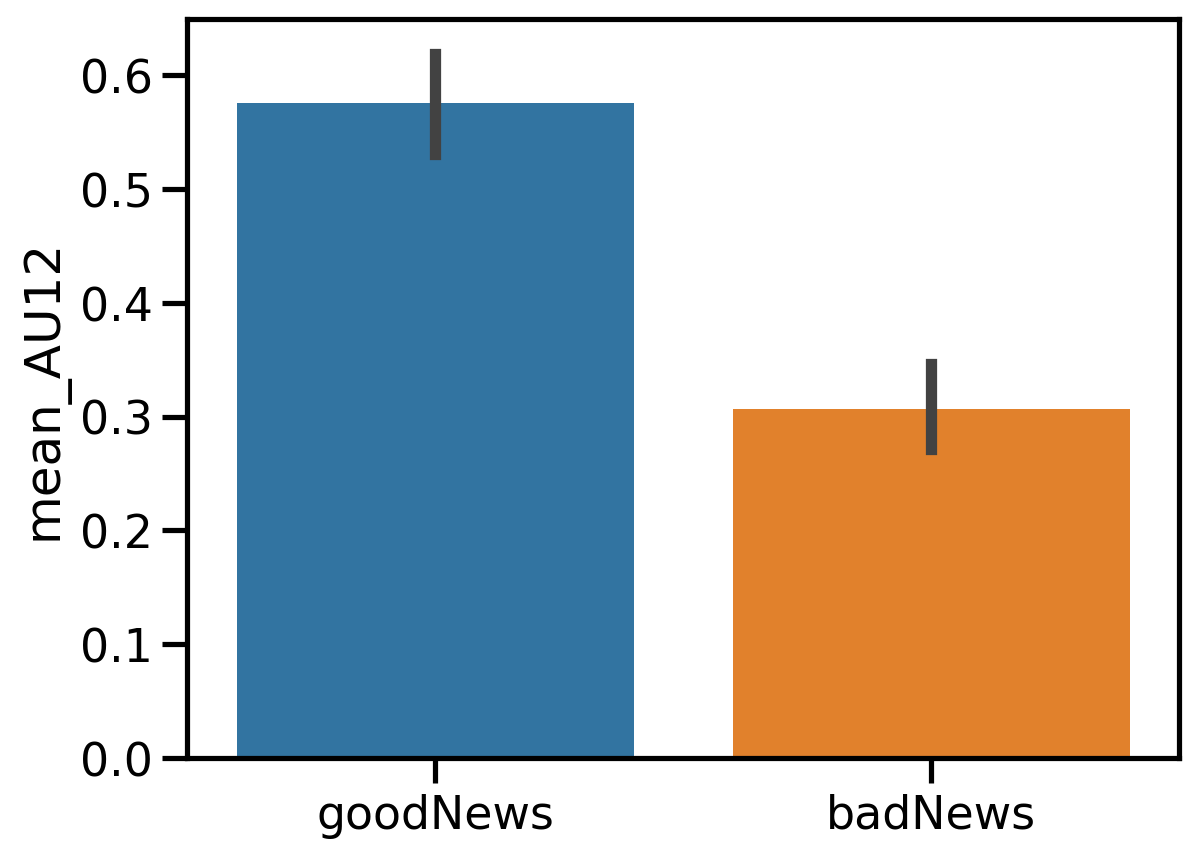

In [9]:
t, p = video_means.ttest_ind(col="mean_AU12")

sessions = video_means.sessions.unique()

print(f"T-test between {sessions[0]} vs {sessions[1]}: t={t:.4g}, p={p:.3g}")
sns.barplot(
    x=video_means.sessions.values,
    y="mean_AU12",
    data=video_means,
)

### 5.5.2 Comparing multiple detections with regression

More often we'll want to run comparisons across multiple detections simulatenously. Because t-tests are just regression we can using the `.regress()` method along with numerical contrasts to corresponding to the condition means to run multiple tests in parallel. For example we can test the difference in activation of every AU when participants received *good* vs *bad*.

This is analogous to the "mass-univariate" GLM approach in fMRI researchnd allows us to identify what AUs are significantly more active in condition vs another:

In [10]:
# This time replace the labels for each condition with a numerical contrast code
# We'll use these contrasts are predictors in our regression
X = pd.DataFrame(
    video_means.sessions.replace({"goodNews": 0.5, "badNews": -0.5})
)

# Add an intercept to the regression
X["intercept"] = 1

# The dependent variable is AU intensity
y = video_means.aus

# Now we get a t-test at every AU
b, se, t, p, df, residuals = fex.regress(X=X, y=y)

# We can perform bonferroni correction for multiple comparisions:
p_bonf = p / p.shape[1]

print("Betas comparing the contrast of good news AU intensity > bad news AU intensity")

results = pd.concat(
    [
        b.round(3).loc[[0]].rename(index={0: "betas"}),
        t.round(3).loc[[0]].rename(index={0: "t-stats"}),
        p_bonf.round(3).loc[[0]].rename(index={0: "p-values"}),
    ]
)

results

Betas comparing the contrast of good news AU intensity > bad news AU intensity


/Users/Esh/anaconda3/envs/py-feat/lib/python3.8/site-packages/nltools/stats.py:1086: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  * sigma[np.newaxis, :]


,mean_AU01,mean_AU02,mean_AU04,mean_AU05,mean_AU06,mean_AU07,mean_AU09,mean_AU10,mean_AU11,mean_AU12,mean_AU14,mean_AU15,mean_AU17,mean_AU20,mean_AU23,mean_AU24,mean_AU25,mean_AU26,mean_AU28,mean_AU43
betas,0.023,0.022,-0.005,-0.159,0.212,0.316,0.081,0.115,0.018,0.269,0.130,-0.039,-0.070,0.196,-0.110,-0.074,0.283,-0.034,-0.002,0.010
t-stats,0.625,1.534,-0.440,-6.718,6.454,7.076,4.558,3.284,9.655,8.688,6.483,-2.223,-4.514,4.222,-4.026,-4.307,4.042,-1.826,-0.049,0.582
p-values,0.027,0.007,0.033,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.002,0.000,0.000,0.000,0.000,0.000,0.004,0.048,0.028


Notice that the results for AU12 are identitical to the single t-test we ran above

## 5.6 Compare conditions with a classifier and emotion features

Another way we can look at differences between conditions is by testing what combination of features can classify between good news or bad news conditions. To do this, we'll train a Logistc Regression classifier using detected emotion intensity as features. We can use the `.predict()` method to help us out.

The results suggest that happy expressions have a very high feature weight when predicting good news: 

In [11]:
from sklearn.linear_model import LogisticRegression

# Features = emotion predictions for each frame
# Labels = experimental condition the frame belonged to
clf, accuracy = fex.predict(
    X=fex.emotions, y=fex.sessions, model=LogisticRegression, solver="liblinear"
)
print(f"Accuracy: {accuracy.mean():.3g} +/- {accuracy.std():.3g}")
print(f"Coefficients for predicting class: {clf.classes_[1]}")
pd.DataFrame(clf.coef_, columns=fex.emotions.columns)


Accuracy: 0.946 +/- 0.0406
Coefficients for predicting class: goodNews


,anger,disgust,fear,happiness,sadness,surprise,neutral
0,-0.51683,-0.060014,-1.91617,6.662003,-3.782449,-0.072228,-2.088377


We can also do the same thing using all the AUs as separate features. The benefit of this approach is that the model can estimate *any* facial expression that useful for prediction rather than only the 7 detected emotions:

In [12]:
clf, accuracy = fex.predict(
    X=fex.aus, y=fex.sessions, model=LogisticRegression
)
print(f"Accuracy: {accuracy.mean():.3g} +/- {accuracy.std():.3g}")
print(f"Coefficients for predicting class: {clf.classes_[1]}")
pd.DataFrame(clf.coef_, columns=fex.aus.columns)


Accuracy: 0.856 +/- 0.0666
Coefficients for predicting class: goodNews


,AU01,AU02,AU04,AU05,AU06,AU07,AU09,AU10,AU11,AU12,AU14,AU15,AU17,AU20,AU23,AU24,AU25,AU26,AU28,AU43
0,0.788891,-0.308574,0.510241,-5.429342,2.876515,0.698696,0.896845,0.083515,0.76983,4.630504,2.299672,0.349986,-1.089859,0.718885,-0.098861,-0.118694,-0.284834,-0.642761,2.5504,-2.224848


Further, we can combine what we learned in the previous tutorial to visualize these feature weights and generate the underlying facial expression that the classifier learned!

<AxesSubplot: title={'left': 'Good vs Bad News Classifier Weights'}>

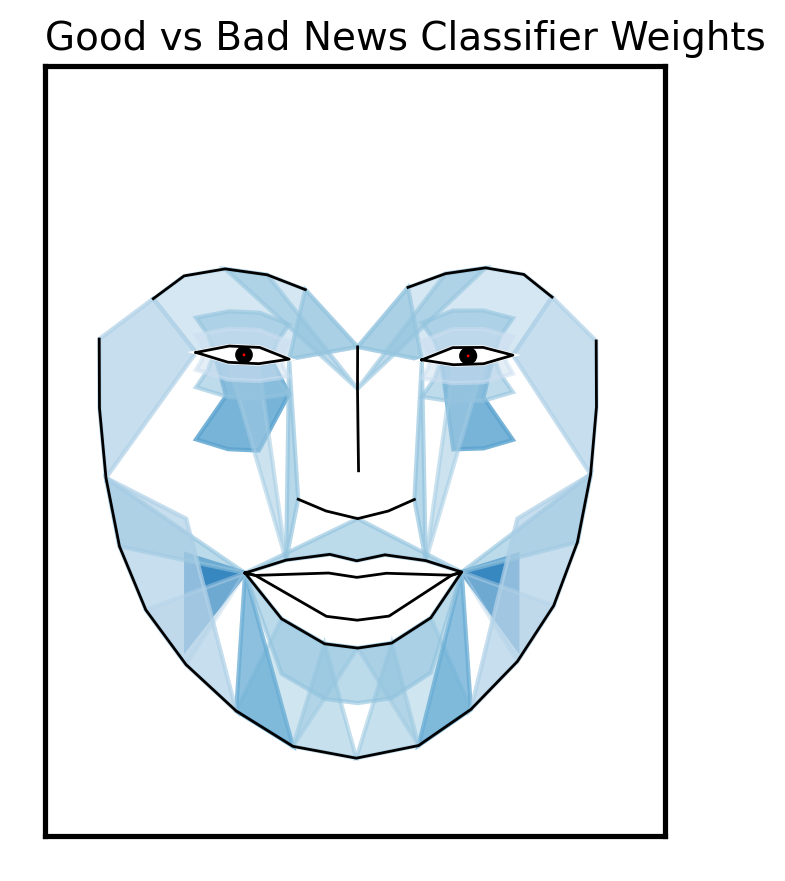

In [13]:
from feat.plotting import plot_face

plot_face(
    au=clf.coef_.squeeze(), 
    feature_range=(0, 1),
    muscles={"all": "heatmap"},
    title="Good vs Bad News Classifier Weights",
)

In [ ]:
from feat.plotting import animate_face

animation = animate_face(
    start='neutral',
    end=clf.coef_.squeeze(),
    feature_range=(0, 1),
    muscles={'all': 'heatmap'},
    title="Good vs Bad News Classifier Weights",
    save="weights.gif",
)

![](./weights.gif)

## 5.7 Time-series correlations

Finally we might be interested in looking the similarity of the detected AU time-series across videos, sessions, or people. To compare the similarity of signals over time, we can use the `.isc()` method which takes an input column. Below we just look at AU 1 and we can get a sense of similar videos were to each other based how AU 1 changed over time. 

Warmer colors indicate a pair of videos elicited more *similar* AU 1 activity over time. We can see just by looking at this AU, how two video cluster seem to emerge reflecting the two experimental conditions: good news and bad news.

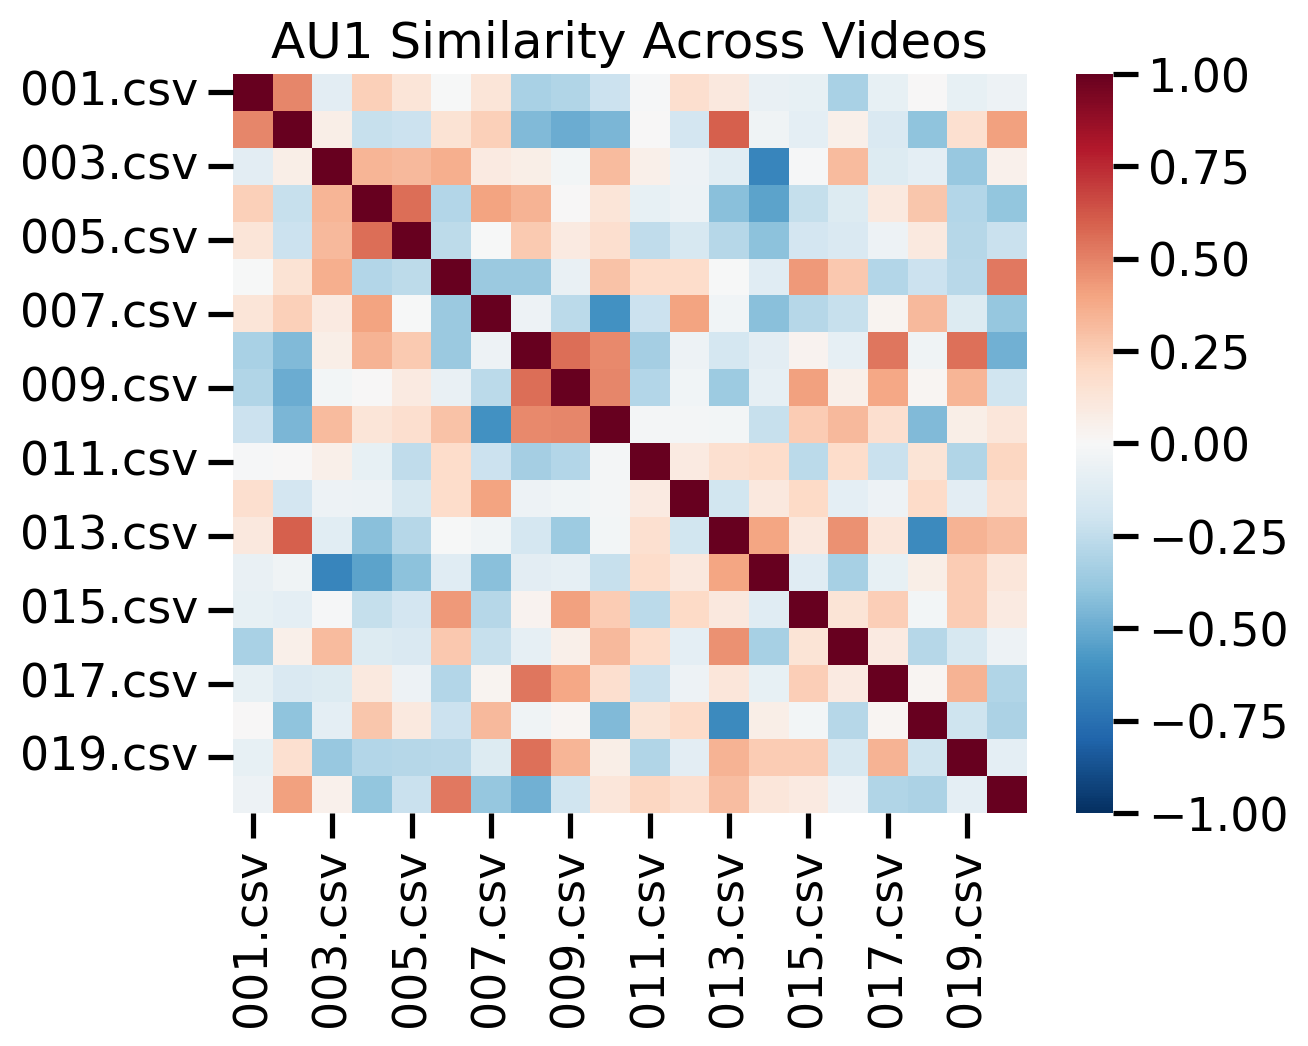

In [23]:
# Set sessions back to unique videos
fex.sessions = fex['input']

# ISC returns a video x video pearson correlation matrix
isc = fex.isc(col = "AU01", method='pearson')
ax = sns.heatmap(isc, center=0, vmin=-1, vmax=1, cmap="RdBu_r")
ax.set(xlabel=None,ylabel=None, title='AU1 Similarity Across Videos');